In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/turtlebot/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:
env = gym.make("CartPole-v0")

/home/turtlebot/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [5]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=0),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).to(device)
        dist, _ = model(state)
        _, action = dist.probs.max(0)
        next_state, reward, done, _ = env.step(action.numpy())
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [7]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [8]:
num_inputs  = env.observation_space.shape[0]
num_outputs = env.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

In [9]:
test_rewards = []

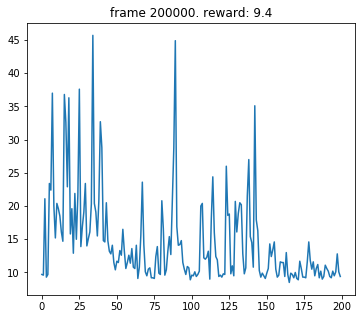

In [10]:
max_frames   = 100000
frame_idx    = 0

state = env.reset()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0
    
    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(torch.FloatTensor([log_prob]))
        values.append(torch.FloatTensor([value]))
        rewards.append(reward)
        masks.append(1 - done)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.FloatTensor(log_probs)
    returns   = torch.FloatTensor(returns).detach()
    values    = torch.FloatTensor(values)

    advantage = returns - values

    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [11]:
dists = []
with torch.no_grad():
    testing_env = gym.make("CartPole-v0")

    for i_episode in range(5):
        observation = torch.FloatTensor(testing_env.reset())
        for t in range(1000):
            testing_env.render()
            dist, _ = model(observation)
            _, action = dist.probs.max(0)
            observation, reward, done, info = testing_env.step(action.numpy())
            observation = torch.FloatTensor(observation)
            dists.append(dist)
            if done:
                break
    testing_env.close()

In [12]:
for i in dists:
    print(i.probs)

tensor([0.5193, 0.4807])
tensor([0.5300, 0.4700])
tensor([0.5345, 0.4655])
tensor([0.5383, 0.4617])
tensor([0.5379, 0.4621])
tensor([0.5372, 0.4628])
tensor([0.5366, 0.4634])
tensor([0.5397, 0.4603])
tensor([0.5453, 0.4547])
tensor([0.5155, 0.4845])
tensor([0.5254, 0.4746])
tensor([0.5321, 0.4679])
tensor([0.5373, 0.4627])
tensor([0.5383, 0.4617])
tensor([0.5371, 0.4629])
tensor([0.5369, 0.4631])
tensor([0.5403, 0.4597])
tensor([0.5194, 0.4806])
tensor([0.5295, 0.4705])
tensor([0.5332, 0.4668])
tensor([0.5368, 0.4632])
tensor([0.5372, 0.4628])
tensor([0.5362, 0.4638])
tensor([0.5357, 0.4643])
tensor([0.5388, 0.4612])
tensor([0.5434, 0.4566])
tensor([0.5497, 0.4503])
tensor([0.5165, 0.4835])
tensor([0.5258, 0.4742])
tensor([0.5300, 0.4700])
tensor([0.5346, 0.4654])
tensor([0.5365, 0.4635])
tensor([0.5361, 0.4639])
tensor([0.5363, 0.4637])
tensor([0.5402, 0.4598])
tensor([0.5454, 0.4546])
tensor([0.5174, 0.4826])
tensor([0.5260, 0.4740])
tensor([0.5301, 0.4699])
tensor([0.5342, 0.4658])


In [13]:
print(log_probs)
print(values)
print(returns)
print(rewards)
print(masks)
print(advantage)
print(entropy)
print(loss)

tensor([-0.4440, -0.4372, -0.4245, -1.0951, -0.3528])
tensor([4.3048, 4.3015, 4.2974, 4.2925, 4.3057])
tensor([0., 0., 0., 0., 0.])
[0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0, 0, 0, 0]
tensor([-4.3048, -4.3015, -4.2974, -4.2925, -4.3057])
tensor(3.1933, grad_fn=<AddBackward0>)
tensor(6.8762, grad_fn=<SubBackward0>)


In [14]:
print(dist.probs)
print(action)

tensor([0.5505, 0.4495])
tensor(0)
